scikit-learn version: 1.6.1
Loaded dataset from: train.csv

Dataset preview:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Dataset shape: (891, 12)

Selected target column: 'Survived' (dtype: int64)
Converted target to numeric (if applicable).

Train shape: (712, 11), Test shape: (179, 11)

Numeric columns (6): ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns (5): ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Using OneHotEncoder(handle_unknown='ignore', sparse_output=False)

Training baseline model...
Training Linear Regression model...

Model performance on TEST set:
Baseline (mean): MAE = 0.478595 | RMSE = 0.493833
Linear Regression: MAE = 0.271727 | RMSE = 0.346532

Summary:


,Model,MAE,RMSE
0,Baseline (mean),0.478595,0.493833
1,Linear Regression,0.271727,0.346532



Saved test-set predictions to: assignment5_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

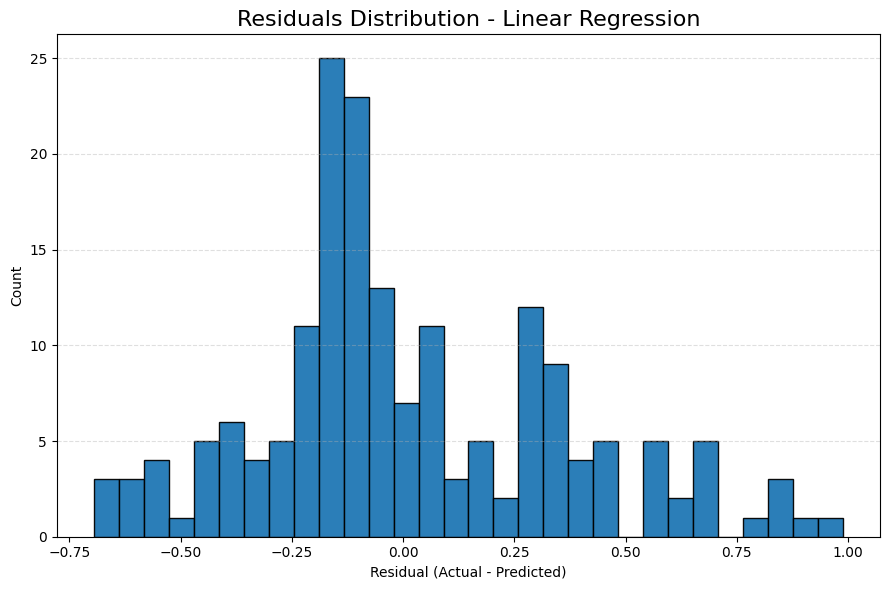

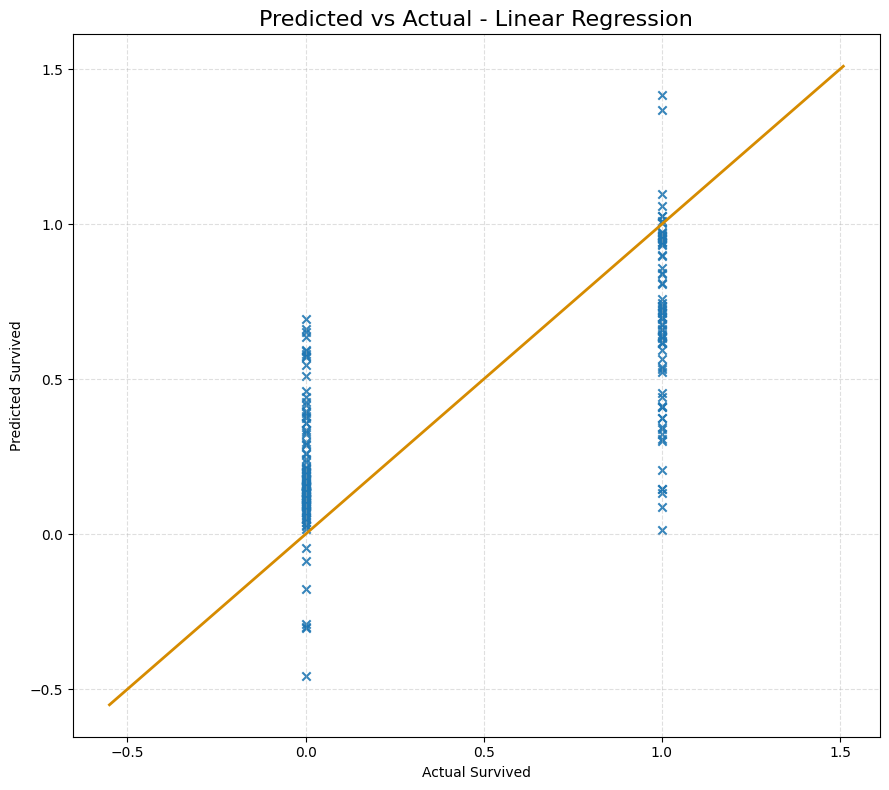


Assignment 5 finished ✅
- If your task is true classification (churn yes/no), use LogisticRegression + classification metrics.
- If OHE creates too many features, consider target encoding or categorical cardinality reduction.


In [8]:
# Assignment 5: Linear Regression - Train/Test split, Baseline comparison (MAE & RMSE)

# --- Imports ------------------------------------------------------------
import os
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ADDED: plotting import (display only, no file saves)
import matplotlib.pyplot as plt

print(f"scikit-learn version: {sklearn.__version__}")

# --- Load dataset -------------------------------------------------------
# If /mnt/data/train.csv exists (e.g., Kaggle workspace), it will be used.
# Otherwise, Colab will prompt you to upload train.csv.
path = "train.csv"  # prefer local file in Colab working dir
if os.path.isfile(path):
    df = pd.read_csv(path)
    print(f"Loaded dataset from: {path}")
else:
    try:
        from google.colab import files
        print("train.csv not found in working directory. Please upload your train.csv now.")
        uploaded = files.upload()
        fname = next(iter(uploaded))
        df = pd.read_csv(fname)
        print(f"Loaded uploaded file: {fname}")
    except Exception as e:
        raise FileNotFoundError("train.csv not found and upload failed.") from e

print("\nDataset preview:")
display(df.head())
print(f"\nDataset shape: {df.shape}")

# --- Target selection ---------------------------------------------------
# Set this manually if auto-detection picks wrong column:
# target_col = 'Churn'   # <-- uncomment & set if you want specific target
try:
    target_col  # type: ignore
except NameError:
    target_col = None

possible_targets = ['Churn', 'churn', 'CHURN', 'Exited', 'exited', 'Exited?', 'target', 'TARGET', 'y', 'label', 'Survived']
if target_col is None:
    for t in possible_targets:
        if t in df.columns:
            target_col = t
            break

if target_col is None:
    # prefer binary-like column
    for c in df.columns:
        if df[c].nunique(dropna=True) == 2:
            target_col = c
            break

if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = numeric_cols[-1] if numeric_cols else None

if target_col is None:
    raise ValueError("Could not detect a target column. Set target_col manually in the code.")

print(f"\nSelected target column: '{target_col}' (dtype: {df[target_col].dtype})")

# --- Ensure target numeric ------------------------------------------------
# Try convert to numeric, else factorize / map to 0/1 when appropriate
try:
    df[target_col] = pd.to_numeric(df[target_col])
    print("Converted target to numeric (if applicable).")
except Exception:
    vals = df[target_col].dropna().unique().tolist()
    if len(vals) == 2:
        mapping = {str(vals[0]): 0, str(vals[1]): 1}
        df[target_col] = df[target_col].astype(str).map(mapping).astype(float)
        print(f"Mapped target values {mapping} -> 0/1")
    else:
        df[target_col] = pd.factorize(df[target_col])[0].astype(float)
        print("Factorized target to numeric codes.")

df[target_col] = pd.to_numeric(df[target_col], errors='coerce').astype(float)

# --- Features / target split --------------------------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

# Basic cleaning: drop constant columns & extremely high-missing columns
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    print(f"Dropping constant columns: {const_cols}")
    X = X.drop(columns=const_cols)

high_missing = [c for c in X.columns if X[c].isna().mean() > 0.90]
if high_missing:
    print(f"Dropping high-missing columns (>90% missing): {high_missing}")
    X = X.drop(columns=high_missing)

# --- Train/test split ---------------------------------------------------
RANDOM_STATE = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- Column identification -----------------------------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNumeric columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# --- Preprocessing -------------------------------------------------------
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatibility with different sklearn versions
try:
    _ = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_args = {'handle_unknown': 'ignore', 'sparse_output': False}
    print("\nUsing OneHotEncoder(handle_unknown='ignore', sparse_output=False)")
except TypeError:
    ohe_args = {'handle_unknown': 'ignore', 'sparse': False}
    print("\nUsing OneHotEncoder(handle_unknown='ignore', sparse=False) [fallback]")

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(**ohe_args))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
], remainder='drop')

# --- Models --------------------------------------------------------------
baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

linreg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# --- Train ----------------------------------------------------------------
print("\nTraining baseline model...")
baseline.fit(X_train, y_train)
print("Training Linear Regression model...")
linreg.fit(X_train, y_train)

# --- Predict -------------------------------------------------------------
y_pred_baseline = baseline.predict(X_test)
y_pred_linreg = linreg.predict(X_test)

# --- Evaluate (MAE & RMSE) ----------------------------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    # RMSE computed version-compatibly
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}: MAE = {mae:.6f} | RMSE = {rmse:.6f}")
    return mae, rmse

print("\nModel performance on TEST set:")
mae_b, rmse_b = evaluate_model("Baseline (mean)", y_test, y_pred_baseline)
mae_l, rmse_l = evaluate_model("Linear Regression", y_test, y_pred_linreg)

# --- Summary table -------------------------------------------------------
results = pd.DataFrame({
    'Model': ['Baseline (mean)', 'Linear Regression'],
    'MAE': [mae_b, mae_l],
    'RMSE': [rmse_b, rmse_l]
})
print("\nSummary:")
display(results)

# --- Save predictions & download (Colab-friendly) ------------------------
out_df = X_test.reset_index(drop=True).copy()
out_df['y_true'] = y_test.reset_index(drop=True)
out_df['pred_baseline'] = y_pred_baseline
out_df['pred_linreg'] = y_pred_linreg

out_path = "assignment5_predictions.csv"
out_df.to_csv(out_path, index=False)
print(f"\nSaved test-set predictions to: {out_path}")

# Trigger download in Colab
try:
    from google.colab import files
    files.download(out_path)
except Exception:
    print("Automatic download failed (maybe not running in Colab). The file is saved in the current directory.")


# -------------------------
# ---  Display plots (no saving) ---
# -------------------------

# 1) Residuals histogram
try:
    residuals = (y_test.values - y_pred_linreg)
    plt.figure(figsize=(9, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.95)
    plt.title("Residuals Distribution - Linear Regression", fontsize=16)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Residuals plot skipped:", e)

# 2) Predicted vs Actual
try:
    actual = y_test.values
    predicted = y_pred_linreg
    mn = min(np.nanmin(actual), np.nanmin(predicted))
    mx = max(np.nanmax(actual), np.nanmax(predicted))
    pad = (mx - mn) * 0.05 if mx > mn else 1.0
    line_x = np.array([mn - pad, mx + pad])
    plt.figure(figsize=(9, 8))
    plt.scatter(actual, predicted, marker='x', alpha=0.9)
    plt.plot(line_x, line_x, linestyle='-', linewidth=2, color=_plot_color)
    plt.title("Predicted vs Actual - Linear Regression", fontsize=16)
    plt.xlabel("Actual " + str(target_col))
    plt.ylabel("Predicted " + str(target_col))
    plt.grid(linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Pred vs Actual plot skipped:", e)


print("\nAssignment 5 finished ✅")
print("- If your task is true classification (churn yes/no), use LogisticRegression + classification metrics.")
print("- If OHE creates too many features, consider target encoding or categorical cardinality reduction.")
